# 1.1 Classification with sklearn

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection  import train_test_split as tts
from sklearn.linear_model import LogisticRegression as lr
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
import sklearn

import numpy as np
import matplotlib.pyplot as plt

digits = load_digits()
print(digits.keys())
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]
import numpy as np
print(data.dtype)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
float64


In [2]:
x_all = data
y_all = target

idx_a = np.where(y_all == 3)
idx_b = np.where(y_all == 8)

x_a = x_all[idx_a]
x_b = x_all[idx_b]
x_a = np.concatenate([x_a, np.ones((x_a.shape[0], 1))], axis=1)
x_b = np.concatenate([x_b, np.ones((x_b.shape[0], 1))], axis=1)

x_ab = np.concatenate([x_a, x_b], axis=0)

y_a = y_all[idx_a]
y_a[y_a==3] = 1
y_b = y_all[idx_b]
y_b[y_b==8] = -1
y_ab = np.concatenate([y_a, y_b], axis=0)

In [3]:
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=213)
cv.get_n_splits(x_ab, y_ab)
np.random.seed(1312)

model = lr(max_iter=2000).fit(x_ab, y_ab)

print("Prediction: ", model.predict(x_ab[:2, :]))
print("Probability: ", model.predict_proba(x_ab[:2, :]))
print("Score: ", model.score(x_ab, y_ab))

cross_scores = cross_val_score(model, x_ab, y_ab, cv=10)
print("Cross-Validation score (10 folds): ", np.mean(cross_scores))

for lmbda in [1e-5, 1e-3, 1e-1, 1, 100, 1e4]:
    model = lr(max_iter=2000, C=lmbda).fit(x_ab, y_ab)
    cross_scores = cross_val_score(model, x_ab, y_ab, cv=10)
    print("Cross-Validation for lambda = %e score (10 folds): %f"%(lmbda, np.mean(cross_scores))) 

Prediction:  [1 1]
Probability:  [[2.22597644e-06 9.99997774e-01]
 [4.60477390e-09 9.99999995e-01]]
Score:  1.0
Cross-Validation score (10 folds):  0.9858730158730159
Cross-Validation for lambda = 1.000000e-05 score (10 folds): 0.937778
Cross-Validation for lambda = 1.000000e-03 score (10 folds): 0.968889
Cross-Validation for lambda = 1.000000e-01 score (10 folds): 0.985873
Cross-Validation for lambda = 1.000000e+00 score (10 folds): 0.985873
Cross-Validation for lambda = 1.000000e+02 score (10 folds): 0.985873
Cross-Validation for lambda = 1.000000e+04 score (10 folds): 0.983095


Selecting $\lambda = 0.1$ for highest generalisation

# 1.2 Optimisation methods

In [4]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def gradient(beta, X, y, lamda):
    return beta/lamda + (1/X.shape[0])*(sigmoid(-y @ X @ beta) * (- y @ X).T)

def predict(beta, X):
    pred = X @ beta
    #pred = np.zeros(X.shape[0])
    #for i in range(X.shape[0]):
    #    pred[i] = np.sum(X[i]*beta)
    pred_3 = (pred > 0).astype(int)*2-1
    return pred_3

def zero_one_loss(y_predictions, y_truth):
    return np.sum(y_predictions!=y_truth)

In [5]:
LAMBDA = 0.1

def timestep(tau0, gamma, t):
    tau = tau0/(1 + gamma*t)
    return tau

def grad_desc(beta, X, y, tau0, gamma, m):
    for t in range(m):
        tau = timestep(tau0, gamma, t)
        beta = beta - tau*gradient(beta, X, y, LAMBDA)
    return beta

def stoch_grad(beta, X, y, tau0, gamma, m):
    for t in range(m):
        tau = timestep(tau0, gamma, t)
        idx = np.random.randint(X.shape[0])
        beta = beta - tau*gradient(beta, X[idx].reshape((1, -1)), y[idx].reshape((1)), LAMBDA)
    return beta

def stoch_grad_minibatch(beta, X, y, tau0, gamma, m, b):
    for t in range(m):
        tau = timestep(tau0, gamma, t)
        idx = np.random.randint(X.shape[0], size=b)
        beta = beta - tau*gradient(beta, X[idx], y[idx], LAMBDA)
    return beta

def stoch_grad_momentum(beta, X, y, tau0, gamma, m, mu):
    g = 0
    for t in range(m):
        tau = timestep(tau0, gamma, t)
        idx = np.random.randint(X.shape[0])
        g = mu*g+(1-mu)+gradient(beta, X[idx].reshape((1, -1)), y[idx].reshape((1)), LAMBDA)
        beta = beta - tau*g
    return beta

def adam(beta, X, y, tau0, gamma, m, mu1, mu2):
    g = 0
    eps = 1e-8
    for t in range(m):
        tau = timestep(tau0, gamma, t)
        idx = np.random.randint(X.shape[0])
        g = mu1*g + (1 - mu1)*gradient(beta, X[idx].reshape((1, -1)), y[idx].reshape((1)), LAMBDA)
        q = mu2*g + (1 - mu2)*gradient(beta, X[idx].reshape((1, -1)), y[idx].reshape((1)), LAMBDA)**2
        
        g_corr = g / (1 - mu1)
        q_corr = q / (1 - mu2)

        beta = beta - tau/(np.sqrt(q_corr) + eps)*g_corr
        
    return beta

def stoch_avg_grad_2(beta, X, y, tau0, gamma, m):
    g_store = np.zeros(X.shape)
    for i in range(X.shape[0]):
        g_store[i] = (-np.dot(y[i], X[i][:,None])*sigmoid(-np.dot(y[i], np.dot(X[i], beta)))).T
    
    # g_store = - y @ X * sigmoid(y @ X @ beta)
    g = 1/len(X)*np.sum(g_store)
    
    for t in range(m):
        tau = timestep(tau0, gamma, t)
        idx = np.random.randint(X.shape[0])
        g_i = -np.dot(y[idx], X[idx].reshape((1,-1 )))*sigmoid(-y[idx]*np.dot(X[idx], beta))
        g = g + 1/len(X)*(g_i - g_store[idx])
        g_store[idx] = g_i
        beta = beta*(1 - tau/LAMBDA) - tau * g
        
    return beta.reshape((-1))

def stoch_avg_grad(beta, X, y, tau0, gamma, m):
    g_store = - (y*X.T).T * sigmoid(-y @ X @ beta)
    g = 1/len(X)*np.sum(g_store, axis=0)

    for t in range(m):
        tau = timestep(tau0, gamma, t)
        idx = np.random.randint(X.shape[0])
        g_i = -1*(np.dot(y[idx], X[idx].reshape((1,-1 )))*sigmoid(-np.dot(y[idx], X[idx] @ beta))).flatten()
        g = g + 1/len(X)*(g_i - g_store[idx])
        g_store[idx] = g_i
        beta = beta*(1 - tau/LAMBDA) - tau * g
        
    return beta

def dual_coord_asc_2(beta, X, y, tau0, gamma, m):
    epsilon = 1
    a = np.random.uniform(size=len(X))
    arr = np.zeros(X.shape)
    for i in range(X.shape[0]):
        arr[i] = (a[i]*np.dot(y[i], X[i][:,None])).T
    beta = LAMBDA/len(X) * np.sum(arr, axis=0)
    # beta = LAMBDA/X.shape[0] * a @ y @ X.T
    
    for t in range(m):
        tau = timestep(tau0, gamma, t)
        idx = np.random.randint(X.shape[0])
        fprime = np.dot(y[idx], np.dot(X[idx], beta)) + np.log(a[idx]/(1 - a[idx]))
        fprimeprime = LAMBDA/len(X)* np.dot(X[idx], X[idx].T) + 1/(a[idx]*(1 - a[idx]))
        a_new = np.clip(a[idx] - fprime/fprimeprime, epsilon, 1-epsilon)
        beta = beta + LAMBDA/len(X)*np.dot(y[idx], X[idx].T)*(a_new - a[idx])
        a[idx] = a_new

    return beta

def dual_coord_asc(beta, X, y, tau0, gamma, m):
    epsilon = 0.0001
    a = np.random.uniform(size=X.shape[0])
    beta = LAMBDA/X.shape[0] * (a @ (y*X.T).T)

    for t in range(m):
        tau = timestep(tau0, gamma, t)
        idx = np.random.randint(X.shape[0])
        fprime = np.dot(y[idx], np.dot(X[idx], beta)) + np.log(a[idx]/(1 - a[idx]))
        fprimeprime = LAMBDA/len(X)* np.dot(X[idx], X[idx].T) + 1/(a[idx]*(1 - a[idx]))
        a_new = np.clip(a[idx] - fprime/fprimeprime, epsilon, 1-epsilon)
        beta = beta + LAMBDA/len(X)*np.dot(y[idx], X[idx].T)*(a_new - a[idx])
        a[idx] = a_new

    return beta

def newton(beta, X, y, tau0, gamma, m):
    z = X @ beta
    y_weighted = y/(sigmoid(np.dot(y,z)))
    
    for t in range(m):
        W = LAMBDA/len(X)*np.dot(sigmoid(z).reshape((-1, 1)), -sigmoid(z).reshape((1,-1)))
        #beta = np.dot(np.dot(np.linalg.inv(np.identity(X.shape[1]) + np.dot(X.T, np.dot(W, X))), X.T), W)@(z + y_weighted)
        beta = np.linalg.inv(np.identity(X.shape[1]) + X.T @ W @ X) @ X.T @ W @ (z + y_weighted)
    return beta#.reshape((-1))

Sampling with replacement because it's easier to implement...

In [6]:
class Model(sklearn.base.BaseEstimator):
    def __init__(self, func):
        self.func=func
    def fit(self, X, y):
        beta0 = np.zeros(X.shape[-1])
        self.beta = self.func(beta0, X, y)
        
    def predict(self, X):
        return predict(self.beta, X)
    
    def score(self, X, y):
        self.y_pred = self.predict(X)
        return zero_one_loss(self.y_pred, y)

tau0_list = [0, 0.01, 0.1]
mu_list = [0.1, 0.2, 0.5]
gamma_list = [0.0001, 0.001, 0.01]

model = Model(lambda beta, X, y:grad_desc(beta, X, y, 0.1, 0.0001, 1000))
model.fit(x_ab, y_ab)
#cross_scores = cross_val_score(model, x_ab, y_ab, cv=10)
#print("Cross-Validation score (10 folds): ", np.mean(cross_scores))

c:\users\bernd\envs\ml_homework_downgrade\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


# 1.3 Comparison

In [10]:
class Model(sklearn.base.BaseEstimator):
    def __init__(self, func, stupid=False):
        self.func=func
        self.stupid = stupid

    def fit(self, X, y):
        beta0 = np.zeros(X.shape[-1])
        if not self.stupid:
            self.beta = self.func(beta0, X, y)
        else:
            self.beta = beta0
        
    def predict(self, X):
        return predict(self.beta, X)
    
    def score(self, X, y):
        self.y_pred = self.predict(X)
        return zero_one_loss(self.y_pred, y)

class RefModel(sklearn.base.BaseEstimator):
    def __init__(self):
        self.model = lr(C=LAMBDA, max_iter=2000)

    def fit(self, X, y):
        self.model.fit(X, y)
        
    def predict(self, X):
        return self.model.predict(X)
    
    def score(self, X, y):
        self.y_pred = self.predict(X)
        return zero_one_loss(self.y_pred, y)

tau0_list = [0.001, 0.01, 0.1]
mu_list = [0.1, 0.2, 0.5]
gamma_list = [0.0001, 0.001, 0.01]


print(' ########## Gradient descent #############')
for tau0 in tau0_list:
    for gamma in gamma_list:
        model = Model(lambda beta, X, y:grad_desc(beta, X, y, tau0, gamma, 10))
        cross_scores = cross_val_score(model, x_ab, y_ab, cv=cv)
        print("Cross-Validation score for gamma = %.2e, tau0 = %.2e, (10 folds): %.2f"%(gamma, tau0, np.mean(cross_scores)))

print(' ########## stochastic descent ########## ')
for tau0 in tau0_list:
    for gamma in gamma_list:
        model = Model(lambda beta, X, y:stoch_grad(beta, X, y, tau0, gamma, 150))
        cross_scores = cross_val_score(model, x_ab, y_ab, cv=cv)
        print("Cross-Validation score for gamma = %.2e, tau0 = %.2e, (10 folds): %.2f"%(gamma, tau0, np.mean(cross_scores)))

print(' ########## stochastic descent minibatch ########## ')
for tau0 in tau0_list:
    for gamma in gamma_list:
        model = Model(lambda beta, X, y:stoch_grad_minibatch(beta, X, y, tau0, gamma, 10000, 10))
        cross_scores = cross_val_score(model, x_ab, y_ab, cv=cv)
        print("Cross-Validation score for gamma = %.2e, tau0 = %.2e, (10 folds): %.2f"%(gamma, tau0, np.mean(cross_scores)))
print(' ########## stochastic descent momentum ########## ')
for tau0 in tau0_list:
    for gamma in gamma_list:
        for mu in mu_list:
            model = Model(lambda beta, X, y:stoch_grad_momentum(beta, X, y, tau0, gamma, 150, mu))
            cross_scores = cross_val_score(model, x_ab, y_ab, cv=cv)
            print("Cross-Validation score for gamma = %.2e, tau0 = %.2e, mu = %.2e (10 folds): %.2f"%(gamma, tau0, mu, np.mean(cross_scores)))
print(' ########## adam')
for tau0 in tau0_list:
    for gamma in gamma_list:
        model = Model(lambda beta, X, y:adam(beta, X, y, tau0, gamma, 150, 0.9, 0.999))
        cross_scores = cross_val_score(model, x_ab, y_ab, cv=cv)
        print("Cross-Validation score for gamma = %.2e, tau0 = %.2e, (10 folds): %.2f"%(gamma, tau0, np.mean(cross_scores)))
print(' ########## stochastic average gradient ########## ')
for tau0 in tau0_list:
    for gamma in gamma_list:
        model = Model(lambda beta, X, y:stoch_avg_grad(beta, X, y, tau0, gamma, 150))
        cross_scores = cross_val_score(model, x_ab, y_ab, cv=cv)
    print("Cross-Validation score for gamma = %.2e, tau0 = %.2e, (10 folds): %.2f"%(gamma, tau0, np.mean(cross_scores)))

print(' ########## dual coord ########## ')
for tau0 in tau0_list:
    for gamma in gamma_list:
        model = Model(lambda beta, X, y:dual_coord_asc(beta, X, y, tau0, gamma, 150))
        cross_scores = cross_val_score(model, x_ab, y_ab, cv=cv)
        print("Cross-Validation score for gamma = %.2e, tau0 = %.2e, (10 folds): %.2f"%(gamma, tau0, np.mean(cross_scores)))

print(' ########## newton ########## ')
for tau0 in tau0_list:
    for gamma in gamma_list:
        model = Model(lambda beta, X, y:newton(beta, X, y, tau0, gamma, 150))
        cross_scores = cross_val_score(model, x_ab, y_ab, cv=cv)
        print("Cross-Validation score for gamma = %.2e, tau0 = %.2e, (10 folds): %.2f"%(gamma, tau0, np.mean(cross_scores)))


 ########## Gradient descent #############
Cross-Validation score for gamma = 1.00e-04, tau0 = 1.00e-03, (10 folds): 1.60
Cross-Validation score for gamma = 1.00e-03, tau0 = 1.00e-03, (10 folds): 1.60
Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-03, (10 folds): 1.60
Cross-Validation score for gamma = 1.00e-04, tau0 = 1.00e-02, (10 folds): 1.60
Cross-Validation score for gamma = 1.00e-03, tau0 = 1.00e-02, (10 folds): 1.60
Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-02, (10 folds): 1.60
Cross-Validation score for gamma = 1.00e-04, tau0 = 1.00e-01, (10 folds): 1.60
Cross-Validation score for gamma = 1.00e-03, tau0 = 1.00e-01, (10 folds): 1.60
Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-01, (10 folds): 1.60
 ########## stochastic descent ########## 


c:\users\bernd\envs\ml_homework_downgrade\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
c:\users\bernd\envs\ml_homework_downgrade\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
c:\users\bernd\envs\ml_homework_downgrade\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Cross-Validation score for gamma = 1.00e-04, tau0 = 1.00e-03, (10 folds): 2.50
Cross-Validation score for gamma = 1.00e-03, tau0 = 1.00e-03, (10 folds): 2.10
Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-03, (10 folds): 2.40
Cross-Validation score for gamma = 1.00e-04, tau0 = 1.00e-02, (10 folds): 13.50
Cross-Validation score for gamma = 1.00e-03, tau0 = 1.00e-02, (10 folds): 14.10
Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-02, (10 folds): 9.10
Cross-Validation score for gamma = 1.00e-04, tau0 = 1.00e-01, (10 folds): 17.40
Cross-Validation score for gamma = 1.00e-03, tau0 = 1.00e-01, (10 folds): 17.60
Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-01, (10 folds): 17.80
 ########## stochastic descent minibatch ########## 
Cross-Validation score for gamma = 1.00e-04, tau0 = 1.00e-03, (10 folds): 1.40
Cross-Validation score for gamma = 1.00e-03, tau0 = 1.00e-03, (10 folds): 1.50
Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-03, (10 folds):

c:\users\bernd\envs\ml_homework_downgrade\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Cross-Validation score for gamma = 1.00e-04, tau0 = 1.00e-01, (10 folds): 15.00


c:\users\bernd\envs\ml_homework_downgrade\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Cross-Validation score for gamma = 1.00e-03, tau0 = 1.00e-01, (10 folds): 10.30


c:\users\bernd\envs\ml_homework_downgrade\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-01, (10 folds): 1.70
 ########## stochastic descent momentum ########## 
Cross-Validation score for gamma = 1.00e-04, tau0 = 1.00e-03, mu = 1.00e-01 (10 folds): 4.00
Cross-Validation score for gamma = 1.00e-04, tau0 = 1.00e-03, mu = 2.00e-01 (10 folds): 4.20
Cross-Validation score for gamma = 1.00e-04, tau0 = 1.00e-03, mu = 5.00e-01 (10 folds): 4.90
Cross-Validation score for gamma = 1.00e-03, tau0 = 1.00e-03, mu = 1.00e-01 (10 folds): 3.60
Cross-Validation score for gamma = 1.00e-03, tau0 = 1.00e-03, mu = 2.00e-01 (10 folds): 3.40
Cross-Validation score for gamma = 1.00e-03, tau0 = 1.00e-03, mu = 5.00e-01 (10 folds): 2.90
Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-03, mu = 1.00e-01 (10 folds): 2.70
Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-03, mu = 2.00e-01 (10 folds): 4.00
Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-03, mu = 5.00e-01 (10 folds): 2.50
Cross-Validation score for gamma

c:\users\bernd\envs\ml_homework_downgrade\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
c:\users\bernd\envs\ml_homework_downgrade\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
c:\users\bernd\envs\ml_homework_downgrade\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt


Cross-Validation score for gamma = 1.00e-03, tau0 = 1.00e-03, (10 folds): 18.30
Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-03, (10 folds): 18.30
Cross-Validation score for gamma = 1.00e-04, tau0 = 1.00e-02, (10 folds): 18.30


c:\users\bernd\envs\ml_homework_downgrade\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
c:\users\bernd\envs\ml_homework_downgrade\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
c:\users\bernd\envs\ml_homework_downgrade\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt


Cross-Validation score for gamma = 1.00e-03, tau0 = 1.00e-02, (10 folds): 18.30
Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-02, (10 folds): 18.30
Cross-Validation score for gamma = 1.00e-04, tau0 = 1.00e-01, (10 folds): 18.30
Cross-Validation score for gamma = 1.00e-03, tau0 = 1.00e-01, (10 folds): 18.30

c:\users\bernd\envs\ml_homework_downgrade\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
c:\users\bernd\envs\ml_homework_downgrade\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt
c:\users\bernd\envs\ml_homework_downgrade\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in sqrt



Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-01, (10 folds): 18.30
 ########## stochastic average gradient ########## 
Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-03, (10 folds): 1.80
Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-02, (10 folds): 2.50
Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-01, (10 folds): 1.90
 ########## dual coord ########## 
Cross-Validation score for gamma = 1.00e-04, tau0 = 1.00e-03, (10 folds): 1.80
Cross-Validation score for gamma = 1.00e-03, tau0 = 1.00e-03, (10 folds): 2.40
Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-03, (10 folds): 1.80
Cross-Validation score for gamma = 1.00e-04, tau0 = 1.00e-02, (10 folds): 1.80
Cross-Validation score for gamma = 1.00e-03, tau0 = 1.00e-02, (10 folds): 2.30
Cross-Validation score for gamma = 1.00e-02, tau0 = 1.00e-02, (10 folds): 1.50
Cross-Validation score for gamma = 1.00e-04, tau0 = 1.00e-01, (10 folds): 1.90
Cross-Validation score for gamma = 1.00e-0

ADAM and Newton don't converge at all, the others converge, but not necessarily to the same value.

c:\users\bernd\envs\ml_homework_downgrade\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


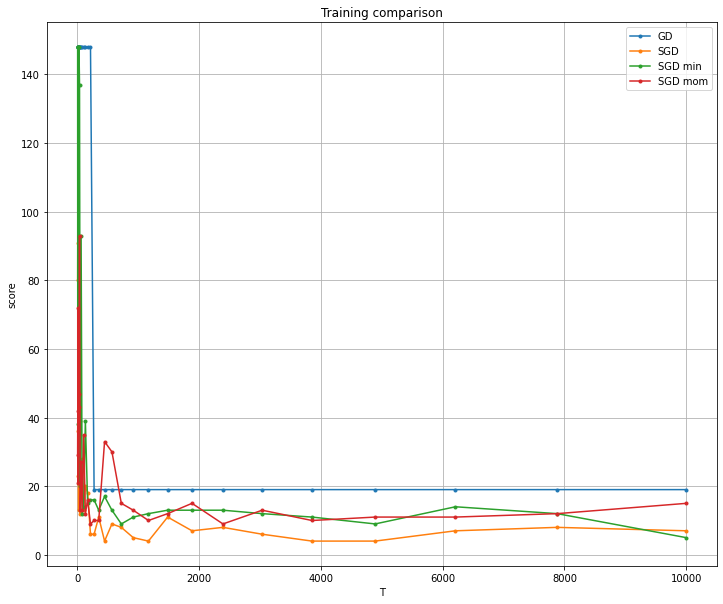

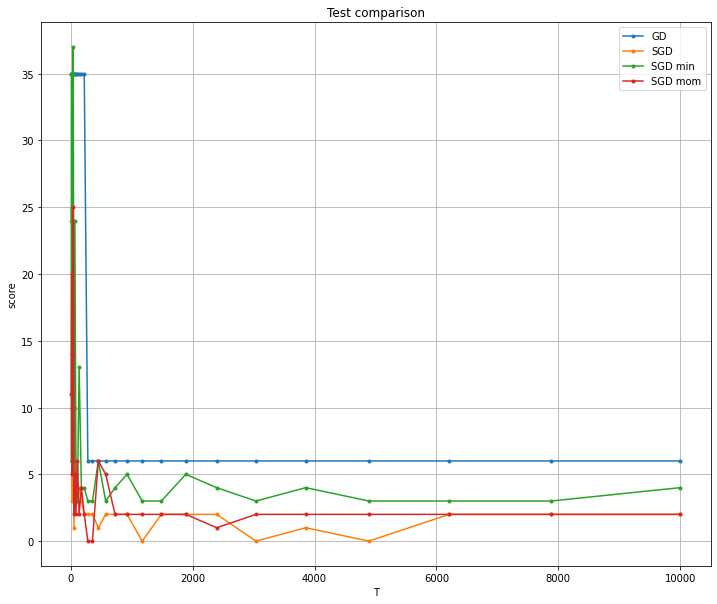

In [9]:
# Speed test and plotting

N_iter_arr = np.logspace(1, 4, 30).astype(int)
X_train, X_test, y_train, y_test = model_selection.train_test_split(x_ab, y_ab, test_size=0.2, random_state=12)


GD_score_train = np.zeros(N_iter_arr.shape)
GD_score_test = np.zeros(N_iter_arr.shape)

for i, N_iter in enumerate((N_iter_arr/256).astype(int)):
    model = Model(lambda beta, X, y:grad_desc(beta, X, y, 0.1, 0.01, N_iter))
    model.fit(X_train, y_train)
    GD_score_train[i] = model.score(X_train, y_train)
    GD_score_test[i] = model.score(X_test, y_test)


SGD_score_train = np.zeros(N_iter_arr.shape)
SGD_score_test = np.zeros(N_iter_arr.shape)

for i, N_iter in enumerate(N_iter_arr):
    model = Model(lambda beta, X, y:stoch_grad(beta, X, y, 1e-3, 1e-2, N_iter))
    model.fit(X_train, y_train)
    SGD_score_train[i] = model.score(X_train, y_train)
    SGD_score_test[i] = model.score(X_test, y_test)


SGD_min_score_train = np.zeros(N_iter_arr.shape)
SGD_min_score_test = np.zeros(N_iter_arr.shape)

for i, N_iter in enumerate((N_iter_arr/10).astype(int)):
    model = Model(lambda beta, X, y:stoch_grad_minibatch(beta, X, y, 1e-3, 1e-2, N_iter, 10))
    model.fit(X_train, y_train)
    SGD_min_score_train[i] = model.score(X_train, y_train)
    SGD_min_score_test[i] = model.score(X_test, y_test)


SGD_mom_score_train = np.zeros(N_iter_arr.shape)
SGD_mom_score_test = np.zeros(N_iter_arr.shape)

for i, N_iter in enumerate(N_iter_arr):
    model = Model(lambda beta, X, y:stoch_grad_momentum(beta, X, y, 1e-3, 1e-2, N_iter, 5e-1))
    model.fit(X_train, y_train)
    SGD_mom_score_train[i] = model.score(X_train, y_train)
    SGD_mom_score_test[i] = model.score(X_test, y_test)

'''
ADAM_score_train = np.zeros(N_iter_arr.shape)
ADAM_score_test = np.zeros(N_iter_arr.shape)

for i, N_iter in enumerate(N_iter_arr):
    model = Model(lambda beta, X, y:adam(beta, X, y, 1e-2, 1e-2, N_iter, 0.9, 0.999))
    model.fit(X_train, y_train)
    ADAM_score_train[i] = model.score(X_train, y_train)
    ADAM_score_test[i] = model.score(X_test, y_test)

SGD_avg_score_train = np.zeros(N_iter_arr.shape)
SGD_avg_score_test = np.zeros(N_iter_arr.shape)

for i, N_iter in enumerate(N_iter_arr):
    model = Model(lambda beta, X, y:stoch_avg_grad(beta, X, y, 1e-2, 1e-2, N_iter))
    model.fit(X_train, y_train)
    SGD_avg_score_train[i] = model.score(X_train, y_train)
    SGD_avg_score_test[i] = model.score(X_test, y_test)

dual_score_train = np.zeros(N_iter_arr.shape)
dual_score_test = np.zeros(N_iter_arr.shape)

for i, N_iter in enumerate(N_iter_arr):
    model = Model(lambda beta, X, y:dual_coord_asc(beta, X, y, 1e-2, 1e-2, N_iter))
    model.fit(X_train, y_train)
    dual_score_train[i] = model.score(X_train, y_train)
    dual_score_test[i] = model.score(X_test, y_test)

newton_score_train = np.zeros(N_iter_arr.shape)
newton_score_test = np.zeros(N_iter_arr.shape)

for i, N_iter in enumerate(N_iter_arr):
    model = Model(lambda beta, X, y:newton(beta, X, y, 1e-2, 1e-2, N_iter))
    model.fit(X_train, y_train)
    newton_score_train[i] = model.score(X_train, y_train)
    newton_score_test[i] = model.score(X_test, y_test)

'''

N = 256
D = 65
B = 10

T_GD_arr = N_iter_arr# * N * D
T_SGD_arr = N_iter_arr# * D
T_SGD_min_arr = N_iter_arr# * D * B

# train plot
plt.figure(0, figsize=((12, 10)))
plt.title("Training comparison")
plt.plot(T_GD_arr, GD_score_train, '.-', label='GD')
plt.plot(T_SGD_arr, SGD_score_train, '.-', label='SGD')
plt.plot(T_SGD_min_arr, SGD_min_score_train, '.-', label='SGD min')
plt.plot(T_SGD_arr, SGD_mom_score_train, '.-', label='SGD mom')
# plt.yscale('log')
# plt.xscale('log')
plt.ylabel("score")
plt.xlabel("T")
plt.legend()
plt.grid()
plt.savefig("training_comp.png")
plt.show()

# train plot
plt.figure(1, figsize=((12, 10)))
plt.title("Test comparison")
plt.plot(T_GD_arr, GD_score_test, '.-', label='GD')
plt.plot(T_SGD_arr, SGD_score_test, '.-', label='SGD')
plt.plot(T_SGD_min_arr, SGD_min_score_test, '.-', label='SGD min')
plt.plot(T_SGD_arr, SGD_mom_score_test, '.-', label='SGD mom')
plt.ylabel("score")
plt.xlabel("T")
plt.legend()
plt.grid()
plt.savefig("test_comp.png")
plt.show()

Convergence time scaled to make prettier plots.

Gradient descent converges weirdly, couldn't find any errors in time though.

Other methods converge (?), but not really the way we'd want them to.

Not really sure what the issue could be.